<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNNPPV/notebooky/cv04-en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training II.

This lab will cover convolutional neural networs, further regularization methods such as BatchNorm and Dropout, data augmentation, more optimizers and the functional API of keras.


In [ ]:
import keras
import numpy as np

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, Activation
from keras.datasets import cifar10
from keras.models import Sequential, Model

import matplotlib.pyplot as plt

## Cifar-10

We will be using the Cifar-10 dataset which contains images in 10 categories.

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


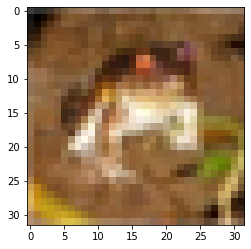

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


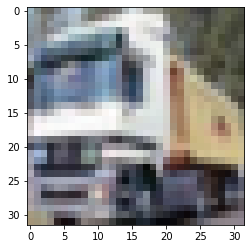

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


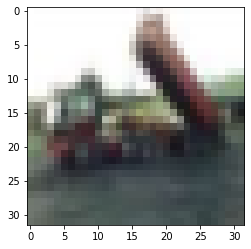

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


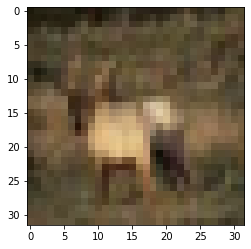

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


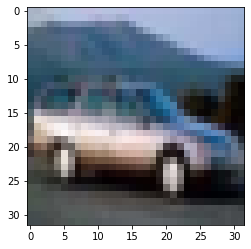

In [ ]:
(x, y), (x_test, y_test) = cifar10.load_data()

num_classes = 10

y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:10000]
y_val = y[:10000]
x_train = x[10000:]
y_train = y[10000:]

print(x.shape)
print(x_test.shape)

for i in range(5):
  plt.imshow(x[i])
  print(y[i])
  plt.show()

## Convolution

If we attempted to use fully connected neural networks for computer vision we would soon reach a problem of extremely large parameter spaces. Too many parameters complicate the training both in the complexity of the parameter space as well as by a higher compute demands.

Due to this we will use the convolutional neural networks. They are based on convolution which is in general defined for two functions $f$ and $g$:

$$ (f \ast g)(t)  = \int_{-\infty}^{\infty} f(x) g(t - x) dx$$


We would usually use this when the support of one of the functions is bounded. In the discrete case for sequences $a_i$ and $b_i$ for $  \in \mathbb{Z}$ we define convolution as:

$$ (a \ast b)_j = \sum_{i \in \mathbb{Z}} a_i \cdot b_{j-i}$$.

In the image we usually use a two-dimensional version with a very small kernel with shapes such as $3 \times 3$, $5 \times 5$ etc. Since these kernels are very often symmetric in standard image processing we can use the term convolution even if in fact it is a correlation (the only difference being a plus sign instea of a minus sign in the calculation). We can think of convolution as multiplication of a pixel neighborhood by the given kernel and further summation of the results. We can see this illustrated: 


![alt text](https://i.stack.imgur.com/YDusp.png)

This approach is used in standard image processing for detection of edges or other important parts of the image. This makes convolution a great tool for use in neural networks. To use it we utilize a layer which applies a convolution to the input. The weights of the kernel are then learned during training.

This is complicated a bit further by the fact that the kernels are not just 2-dimensional (such as $3 \times 3$), but three dimensional where the third dimension corresponds to the number of input channel. Additionally each layer has multiple of these kernels. The output of such layer would therefore be a so-called feature map with the number of channels equal to the number of kernels.

When applying convolution we have to consider what happens at the edges of of the image/feature map. Sometimes we apply the kernel in a way in which it is always contained in the image. We can also pad the input with zeroes and apply the kernels in a way in which we apply the convolution. Another possible modification is the stride which determines how far apart the convolution is applied. E.g. a higher stride means that we would "skip" some placements of the convolution such as every other one.

For one dimension of the input image (height or width independetly):

$$ N_{out} = \frac{N_{in} - F + 2P}{S} + 1,$$

where $N_{out}$ is the output size, $N_{in}$ is the input size, $F$ is the size of the kernel, $P$ is the padding and $S$ is the stride.

*Note.:* Since we have multiple channels in the network it is therefore meaningful to use a $1 \times 1$ convolution. This is usually done to reduce/increase the number of channels.


## Pooling

Convolution is often used along with the so-called pooling layers. They are used primarily to reduce the dimensions of the image which leads to decreased spatial requirements and the subsequent ability to use more channels deeper in the network. This type of layer separates the input into smaller subsets such as $2 \times 2$ windows and reduces the values contained in the subsets to just one nubmer. This is very often done using maximum or mean.



![alt text](https://qph.fs.quoracdn.net/main-qimg-cf2833a40f946faf04163bc28517959c)

## Flatten and Global Pooling

At the end of the network we would still want to use some fully connected layers. In order to do so we need to reduce the number of dimensions (tensor order). To do this we can either use the flatten layer which reorders the features of the tensor into a vector.

This is not always the best choice since the size of the resulting vector can be huge. Therefore the so-called global pooling is often applied instead. Global pooling is similar to standart pooling, but it reduces all of the features in one channel to one number. Usually when using Global pooling we will be using the mean pooling which is contrary to practice of using mostly the max pooling elsewhere in the network.

## Activation functions

The choice of activation function is a crucial one when designing neurnal networks. You will learn more about them in the homework assignment. Today we will use the ReLU (rectified linear unit) activation function, which has two main advantages over sigmoid. The first one is the fact that is is much cheaper to calculate (its derivative is also either 1 or 0) and second one is the fact that it does not suffer as much from the problem of vanishing gradients.

ReLU is quite popular, but it has some ubdesirable properties. There are multiple variations of ReLU which address these such as PReLU, ELU and Leaky ReLU which you can use in your homework assignment.

## Optimization

So far we have used the SGD optimization. This is rather sensitive to the training step. To avoid dealing with that we will use the Adam optimizer. You will work with some other optimizers in your homework assignment.

## Simple CNN model

We will now design a simple model of a convolutional neural network.

For the convolution layers the first parameter is the amount of convolutional layers (this is equal to the number of output channels). Futher arguments are the sizes of kernels, padding and stride. For even more configurations please consult the documentation.

For pooling layers the most important parameter is the size of the pooling window.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

Epoch 1/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3727 - accuracy: 0.5016 - val_loss: 1.0059 - val_accuracy: 0.6416
Epoch 2/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8952 - accuracy: 0.6863 - val_loss: 0.8586 - val_accuracy: 0.7000
Epoch 3/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.6840 - accuracy: 0.7594 - val_loss: 0.7559 - val_accuracy: 0.7374
Epoch 4/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4980 - accuracy: 0.8252 - val_loss: 0.8169 - val_accuracy: 0.7302
Epoch 5/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3351 - accuracy: 0.8831 - val_loss: 0.8904 - val_accuracy: 0.7334
Epoch 6/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2093 - accuracy: 0.9283 - val_loss: 1.0480 - val_accuracy: 0.7262
Epoch 7/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.1447 - accuracy: 0.9495 - val_loss: 1.2348 - val_accuracy:

## Data augmentation

In order do get a better model we would ideally want more data. These are however quite difficult to obtain. We will therefore use augmentation which is based on application of transformations on our existing images such that the semantic concent of the image remains the same. We can also think of augmentation as a process that ensures that our network is invariant to the given augmentation transformations.

In keras we will use the data augmentation by using the ImageDataGenerator class instead of x_train and y_train. We do not augment the validation data. This might get a bit difficult if the augmentation requires some data to be stored (such as some normalization parameters). Very often it is a good idea to write your own data generator. We will cover this in the next lab.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,  # randomly flip images
    preprocessing_function=None)


# The following is called to set the parameters of the generator such as data
# processing for centering or division by the standard deviation.
# Note if use this then we need to peform the same operation on the data
# when testing by calling x = datagen.standardize(np.copy(x))

# datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# namiesto fit používame fit_generator, ktorý vytvoríme pomocou metódy
# flow na trénovacie dáta. Validačné necháme tak
model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=32),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    workers=4)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5110 - accuracy: 0.4478 - val_loss: 1.1375 - val_accuracy: 0.5898
Epoch 2/30
1250/1250 [==============================] - 23s 19ms/step - loss: 1.1057 - accuracy: 0.6088 - val_loss: 0.9644 - val_accuracy: 0.6632
Epoch 3/30
1250/1250 [==============================] - 24s 19ms/step - loss: 0.9355 - accuracy: 0.6701 - val_loss: 0.7914 - val_accuracy: 0.7254
Epoch 4/30
1250/1250 [==============================] - 24s 19ms/step - loss: 0.8332 - accuracy: 0.7096 - val_loss: 0.8360 - val_accuracy: 0.7124
Epoch 5/30
1250/1250 [==============================] - 23s 19ms/step - loss: 0.7725 - accuracy: 0.7304 - val_loss: 0.7524 - val_accuracy: 0.7337
Epoch 6/30
1250/1250 [==============================] - 24s 19ms/step - loss: 0.7191 - accuracy: 0.7487 - val_loss: 0.7136 - val_accuracy: 0.7549
Epoch 7/30
1250/1250 [==========================

## Dropout

Last time we covered the L1 and L2 regularization. Today we will work with the Dropout method which is based on the idea that some random connections in the network will be ignored in each step. The goal of this is to prevent the feature coadaptaion which occurs when the network learns to recognize two very similar features. Since their values are similar so will their gradients which would mean that there would be no easy way for the optimizer to change them in a way in which they are no longer similar. If we add dropout these network features have the opportunity to undergo different changes. A different intuitive explanation of Dropout is that we are actually training multiple neural networks (represented by all of the combinations in which the neurons can be disabled) at the same time and at the end we just combine them all into one.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=32),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    workers=4)

Epoch 1/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6781 - accuracy: 0.3800 - val_loss: 1.3362 - val_accuracy: 0.5061
Epoch 2/30
1250/1250 [==============================] - 23s 19ms/step - loss: 1.3478 - accuracy: 0.5167 - val_loss: 1.0603 - val_accuracy: 0.6178
Epoch 3/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.2046 - accuracy: 0.5710 - val_loss: 1.0499 - val_accuracy: 0.6264
Epoch 4/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.1254 - accuracy: 0.5989 - val_loss: 0.9527 - val_accuracy: 0.6589
Epoch 5/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0587 - accuracy: 0.6263 - val_loss: 0.8759 - val_accuracy: 0.6923
Epoch 6/30
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0132 - accuracy: 0.6456 - val_loss: 0.8394 - val_accuracy: 0.7040
Epoch 7/30
1250/1250 [==============================] - 23s 19ms/step - loss: 0.9747 - accuracy: 0.6560 - val_loss: 0.8212 -

## BatchNormalization

Batch normalization solves the problem of the internatl covariance shift within the network which normally results in the features not being distributed evenly in the vaious layers of the network. This might be crucial especially for deeper networks.

Batchnorm works by calculating the mean and standard deviation for one minibatch of data in the given layer. The features are then normalized by subtracting the mean and dividing by the standard deviation:

$$\hat{x} = \frac{x - \bar{x}}{\sqrt{\sigma^2(x) + \epsilon}}.$$


Since the normal distribution we would obtain from this is not neccessarily the most optimal one we also apply two trainable parameters $\gamma$ and $\beta$:

$$y = \gamma \hat{x} + \beta.$$

This allows the network to learn a different shape of distribution for the network.

During inference we usually do not obtain a batch, or even if we do it is often not in a random order. Therefore the layer saves the mean and standard deviation during training.

BathNorm is usually applied before the activation function. We therefore have to separate convolutional (or dense) layer and the activation by using a separate activation layer.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Homework assignment

The aim of the first homework assignment is to practically test the elements of the CNNs we have just discussed. The assignment has multiple parts. The output of the asignemnt may be a multiple notebooks or python scripts which you used to run the experiments. You submission also has to contain a pdf file with the results including graphs or tables which support your conclusions.

The main task is to train a CNN on the Cifar-10 dataset. You will evaluate how the various modifications of the network work against a common baseline.

### Base model (1b)

The goal is to design a base model which is ideally as fast as possible and sould reach ~70 percent accuracy on the Cifar-10 dataset. You will then use this model as a baseline for further modifications. The base model will use the ReLU activation and the Adam optimizer. The model should contain a few convolutional and pooling layers at the beginning and some fully connected layers at the end.

In the following subtasks you need to change some aspec of the model and compare how they work using graphs which show how the validation accuracy and loss changes. You may also use a table of final results instead.

### Activations (3b)

Try to use different activation functions. Test three of the following sigmoid, tanh, ELU, LeakyReLU or PReLU. You may also test out LeakyReLU for using differnt values for the parameter alpha.

To use Leaky ReLU and PReLU you will need to check the [documentation](https://keras.io/layers/advanced-activations/)

### Optimization (6b)

Test out the training using the Adam, SGD or RMSProp optimzers. Test at least four different configurations (different optimizer, trainig step or some other hyperparameter). When evaluating the results it would be beneficial to use a graph.

Pick one of these configurations and additionally check 3 different minibatch sizes with it.

### Dropout and Augmentation (6b)

Test the dropout first just in the fully connected layer (p = 0.5) and then in the convolutional layers as well (p = 0.2). Test out one additional different placements or the probabilities of the Dropout layer.

Test the augmentation for 3 different settings for both cases.

Perform both of these on the original train/val split and special case where you only use 1000 training images. Please do note that if the trainig set is smaller so will be the number of steps per epoch so you need to adjust either the number of steps or the number of epochs accordingly.

### Deeper network (5b)

Design a deep network (at least 11 layers, but the network can be very thin). Test it out at first without BatchNorm, residual or dense connections or auxillary training layers. Test out at least two of these approaches so that you end up with at least 3 models.

Note: If you plan to use residual or dense connections you have to design the network in a way which allows their placement somewhere in the network.

### Best model (3b)

Produce a model which will reach the best result. These points are additional are not counted towards the assignment maximum of 20 points. Your results will be compared against the results of the rest of the calss. Send the model in the h5 format and include a script which runs the model on the test data and prints out the accuracy.

You can seek insipiration online, but do not use any pretrained networks. If you use something we have not covered so far in the labs please elaborate on how it works and why it should work. 

## Grading

This is assignment is rather straightforward and the goal is for you to gain experience. This assignment might be a bit more time consuming since running the training might take quite some time.

You can select multiple different parameters so feel free to also select some that are nonsensical since knowing what does not work is also quite important. However you may lose points if there are not meaningful parameters tested in any of the sections of the assignment. Ideally after the few initial tries you would try to find the best settings for the hyperparameters that work. The pdf accompanying this assignemnt should also include some commentary on your experiments. I will subtract some points if this commentary will make untrue or nonsensical statements.

## Submission

Submit the assignment in a zip file with notebooks/scripts, the pdf with results and optionally your model to kocurvik@gmail.com.

Make sure that the pdf if file is split into sections and ideally subsections as well. For each result please add some commentary.

Deadline is **6.11. 23:59**. If you submit late you might get some points subtracted.



# Keras functional API

Now we will go through the process of creating a functional model in keras. This model allows us to construct the computational graf in a non-sequential manner. This works by using the fact that all of the layers are callable. If we call a layer with the output of a different layer as its arugemnt this will create a connection in the graph. One instance of a layer can be used multiple times. For an example we will again to turn to the MNIST dataset.


In [ ]:
from keras.datasets import mnist

(x, y), (x_test, y_test) = mnist.load_data()
x = np.reshape(x,(-1,784)).astype(np.float32) / 255
x_test = np.reshape(x_test,(-1,784)).astype(np.float32) / 255
y = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

x_train = x[:50000]
y_train = y[:50000]
x_val = x[50000:]
y_val = y[50000:]

11493376/11490434 [==============================] - 0s 0us/step


In order to have an input we need and Input layer. There can be multiple inputs in a functional model. The model is then created as an instance of the Model class which uses the inputs and outputs argument in its constructor.


In [ ]:
from keras.layers import Input
from keras.models import Model

In [ ]:
inputs = Input(shape=(784,))

output_1 = Dense(64, activation='relu')(inputs)
output_2 = Dense(64, activation='relu')(output_1)
predictions = Dense(10, activation='softmax')(output_2)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train) 

1563/1563 [==============================] - 4s 2ms/step - loss: 0.3028 - accuracy: 0.9119


So far this is not really impressive, but we can also create a much more complicated model. For example we may want our model to do two distinct things. For example we want it to classify the input number and also tell us if it is odd or even.

Let us first generate the odd-even labels.

In [ ]:
def odd_even(y):
  arg = np.argmax(y, axis = -1)
  return np.where(arg % 2 == 0, 1, 0)

y2 = odd_even(y)
y2_train = y2[:50000]
y2_val = y2[50000:]
y2_test = odd_even(y_test)

print(y2_val)

[0 1 1 ... 0 1 1]


We can now create the model. Since we want to look at the model architecture it is a good practice to name the layers.

The model has two outputs and therefore we will need to assign two losses upon compilation. This is done by setting the keyword loss to be a list of loss functions. The fit method then also expects a list of training exapmles.

In [ ]:
input_1 = Input(shape=(784,), name='input_1')
hidden_1_out = Dense(30, activation='relu', name='hidden_1')(input_1)
hidden_2_out = Dense(30, activation='relu', name='hidden_2')(hidden_1_out)

hidden_class_out = Dense(20, activation='relu', name='hidden_class')(hidden_2_out)
predict_class_out = Dense(10, activation='softmax', name='predict_class')(hidden_class_out)

hidden_pair_out = Dense(20, activation='relu', name='hidden_pair')(hidden_2_out)
predict_pair_out = Dense(1, activation='sigmoid', name='predict_pair')(hidden_pair_out)

model = Model(inputs=input_1, outputs=[predict_class_out, predict_pair_out])

model.compile(optimizer='adam', loss= ['categorical_crossentropy', 'binary_crossentropy'], loss_weights=[0.2, 1], metrics=['accuracy'])

print(model.summary())

model.fit(x_train, [y_train, y2_train], validation_data = (x_val,[y_val, y2_val]), batch_size=32, epochs=10)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 30)           23550       input_1[0][0]                    
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           930         hidden_1[0][0]                   
__________________________________________________________________________________________________
hidden_class (Dense)            (None, 20)           620         hidden_2[0][0]                   
_______________________________________________________________________________________

We can also plot the model.

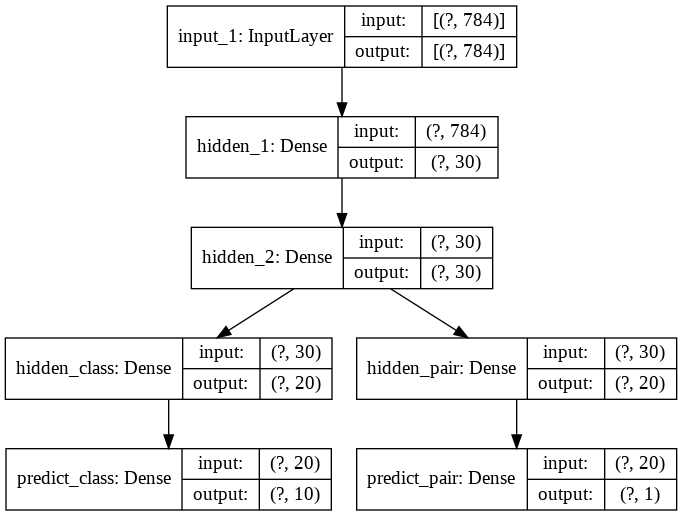

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

We can also test the model

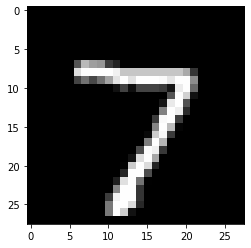

7
4.86536e-07


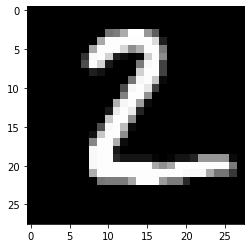

2
0.99986696


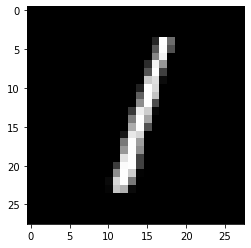

1
0.00017621895


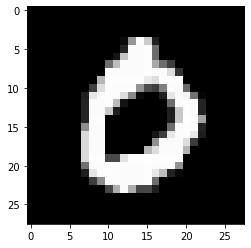

0
0.999998


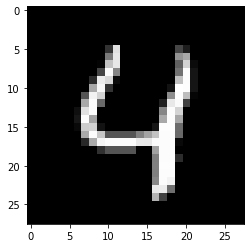

4
0.99996185


In [ ]:
for i in range(5):
  out = model.predict(x_test[np.newaxis,i,:])
  plt.imshow(np.reshape(x_test[i],(28,28)), cmap='gray')
  plt.show()
  print(np.argmax(out[0]))
  print(out[1][0,0])

## Exercise 1

Create a model which will take as an input two images of numbers and on the output we will obtain a classification into two classes (0 and 1) based on whether their sum is greater than 10 or not. Usually we would generate the data via a custom generator, but for now we will just create random pairs of training images and use that as the input. We will do this by permuting the indices. If you do this beware that you need to permute both the images and the labels in the same way.

In [ ]:
idxs = np.random.permutation(60000)
x2 = x[idxs,:]
y2 = y[idxs,:]

idxs_test = np.random.permutation(10000)
x2_test = x[idxs_test,:]
y2_test = y[idxs_test,:]

Implement a funciton which will output the labels for out model. 1 if the sum is greater than 10 and 0 othewise.

In [ ]:
def get_above10(y1, y2):
  ...

In [ ]:
y_above10 = get_above10(y,y2)
y_above10_test = get_above10(y_test,y2_test)

x2_train = x2[:50000]
y_above10_train = y_above10[:50000]
x2_val = x2[50000:]
y_above10_val = y_above10[50000:]

In the following block create a code for a network which will have two inputs. These two inputs will both be independtaly get processed by the same layer (different activations, but samw weights). E.g. it is necessary to call the same instance of a layer on two different inputs. We will therefore have two layers which are "shared but separate". If this is not clear please consult the [docs.](https://keras.io/getting-started/functional-api-guide/)

Next is is necessary to join these two branches. We will do this by using the keras.layers.concatenate layer, which takes a list of tensors to concatenate as its argument.

The rest is then easy. Training is similar to the example above, but we will need to provide a list of inputs instead of a list of outputs.

In [ ]:
...


You can check your work here.

In [ ]:
for i in range(5):
  out = model.predict([x_test[np.newaxis,i,:], x_test[np.newaxis,i+500,:]])
  plt.imshow(np.reshape(x_test[i],(28,28)), cmap='gray')
  plt.show()
  plt.imshow(np.reshape(x_test[i+500],(28,28)), cmap='gray')
  plt.show()
  print(out[0,0])

## Úloha 2

In the following two exercises we will modify the code below. We will also use the Cifar-10 dataset.

The goal of this exercise is to implement a so-called residual connection. This connection is characterized by adding the output of one layer to the output of a layer that is deeper in the model. In order for this to work we need the layers to have the same sizes of ouput. We therefore need to use the keyword padding='same'. If we want a different number of channels we can utilize the $1\times 1$ convolution. To add the outputs use the keras.layers.add

V tejto úlohe bude cieľom vytvoriť tzv. reziduálne prepojenie. To je charakterizované ako sčítanie výstupu jednej vrstvy s nejakou vrstvou ktorá je v modeli neskôr. Na to aby to šlo samozrejme musia mať rovnaké rozmery. Pri konvolúciach potom používame padding='same'. Ak chceme mať rôzny počet kanálov, tak použijeme $1 \times 1$ konvolúciu. Na sčítanie výstupov z dvoch vrstiev použite keras.layers.add

![alt text](https://miro.medium.com/max/1226/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

If you managed to implement this you can also create the so-callec dense connections which do not add, but just concatenate the outputs. Do implement this you can use the keras.layers.concatenate.

In [ ]:
from keras.layers import GlobalAveragePooling2D

In [ ]:
(x, y), (x_test, y_test) = cifar10.load_data()

num_classes = 10

y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:10000]
y_val = y[:10000]
x_train = x[10000:]
y_train = y[10000:]

In [ ]:
def res_layer(h_filters, out_filters, reduce_vol = False):
  
  def _f(x):
    ...
  return _f

In [ ]:
input_1 = Input(shape=(32,32,3))
out_1 = Conv2D(32,(3,3), padding='same', activation='relu')(input_1)
out_2 = res_layer(32,32)(out_1)
out_3 = res_layer(32,32)(out_2)
out_4 = res_layer(64,32(out_3)

out_4_1 = GlobalAveragePooling2D()(out_4)
out_4_2 = Dense(64, activation='relu')(out_4_1)
out_4_3 = Dense(32, activation='relu')(out_4_2)
out_4_3 = Dense(10, activation='softmax')(out_4_3)

model = Model(input=input_1, output=out_4_3)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
print(model.summary())

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

Now implement the case where we also reduce the dimensions of the image/feature maps. We can do this by using a stride in the first layer of the block. When performing the addition we then perform one more strided convolution. Change the function which returns the block so that this behaviour works when reduce_vol=True.

In [ ]:
input_1 = Input(shape=(32,32,3))
out_1 = Conv2D(32,(3,3), padding='same', activation='relu')(input_1)
out_2 = res_layer(32,32)(out_1)
out_3 = res_layer(64,32)(out_2)
out_4 = res_layer(64,64,reduce_vol=True)(out_3)

out_5 = res_layer(64,64)(out_4)
out_6 = res_layer(128,64)(out_5)
out_7 = res_layer(128,128,reduce_vol=True)(out_6)

out_7_1 = GlobalAveragePooling2D()(out_7)
out_7_2 = Dense(64, activation='relu')(out_7_1)
out_7_3 = Dense(32, activation='relu')(out_7_2)
out_7_3 = Dense(10, activation='softmax')(out_7_3)

model = Model(input=input_1, output=out_7_3)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
print(model.summary())

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

## Exercise 3

In the early boom of deep learning one way how deep nets were trained was by using the so-called auxilary training layers, which have their own loss function earlier in the network. Design a deeper neural net which uses such an auxillary training layer.

In [ ]:
...